## Adversarial Image Finder

Adds noise to images to make them look like other things to the network.

Solution to picoCTF 2018 Dog or Frog (900 points)

In [1]:
%matplotlib inline

from keras.applications.mobilenet import preprocess_input
from keras.models import load_model, Model
from keras.preprocessing.image import img_to_array, array_to_img
from keras.layers import Dense, Input, Reshape, Lambda
from keras import optimizers
import keras.backend as K
from PIL import Image
from imagehash import phash
import numpy as np
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


### Useful Variables

In [27]:
IMAGE_DIMS = (224, 224)
TREE_FROG_IDX = 31
TREE_FROG_STR = "tree_frog"

### Helper Functions

(Provided by picoCTF)

In [3]:
def hash_hamming_distance(h1, h2):
    s1 = str(h1)
    s2 = str(h2)
    return sum(map(lambda x: 0 if x[0] == x[1] else 1, zip(s1, s2)))


def is_similar_img(path1, path2):
    image1 = Image.open(path1)
    image2 = Image.open(path2)

    dist = hash_hamming_distance(phash(image1), phash(image2))
    return dist <= 1


def prepare_image(image, target=IMAGE_DIMS):
    # if the image mode is not RGB, convert it
    if image.mode != "RGB":
        image = image.convert("RGB")

    # resize the input image and preprocess it
    image = image.resize(target)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    # return the processed image
    return image

### Preprocess image and model

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


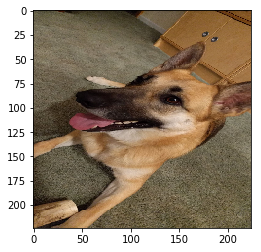

In [4]:
test = Image.open("./trixi.png").resize(IMAGE_DIMS)
plt.imshow(test);
test = prepare_image(test)
model = load_model("./model.h5")

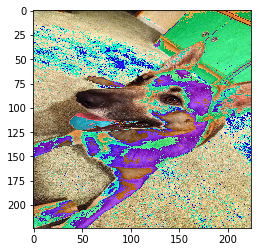

In [5]:
plt.imshow(np.squeeze(test))

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

### Construct new network to train on pixels

In [7]:
K.set_learning_phase(1)
tempInput = Input((1,))
v = Dense(IMAGE_DIMS[0]*IMAGE_DIMS[1]*3, use_bias=False)(tempInput)
v = Reshape(IMAGE_DIMS+(3,), name="reshape_3")(v)
model.trainable = False
K.set_learning_phase(0)
layers = [l for l in model.layers]
layers[1].trainable = False
x = layers[1](v)
for i in range(2, len(layers)):
    layers[i].trainable = False
    x = layers[i](x)
'''for i in range(len(layers)-3, len(layers)):
    layers[i].trainable = False
    x = layers[i](x)'''          
#x = Lambda(lambda x: K.expand_dims(x[:,TREE_FROG_IDX]))(x)

m2 = Model(inputs=tempInput, outputs=x)

In [8]:
m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 150528)            150528    
_________________________________________________________________
reshape_3 (Reshape)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
__________

### Horrible hack to represent pixel values as fully connected weights

In [9]:
tempWeights = m2.get_weights()
tempWeights[0] = np.reshape(test, (1,IMAGE_DIMS[0]*IMAGE_DIMS[1]*3))
m2.set_weights(tempWeights)

### Training

In [10]:
m2.compile(optimizer=optimizers.Adam(lr=0.01),
          loss='mean_squared_error', # Categorical cross-entropy would be more fitting, just picked it and ran with it, but you might get faster convergence if you go the other way
          metrics=['accuracy'])

In [11]:
#x = np.expand_dims(np.array([1.]), axis=0)
x = np.array([1.]*1)
#y = x
y = keras.utils.to_categorical([TREE_FROG_IDX], num_classes=1000)

In [12]:
while m2.predict(np.expand_dims(np.array([1.]), axis=0))[0][TREE_FROG_IDX]<0.99:
    m2.fit(x, y, epochs=10, batch_size=1, verbose=0, validation_data=(x,y))
    # Oh no this is another horrible hack to make sure image pixels don't go out of bounds
    tempWeights = m2.get_weights()
    tempWeights[0][tempWeights[0]>1] = 1
    tempWeights[0][tempWeights[0]<-1] = -1
    m2.set_weights(tempWeights)
    print(m2.predict(x)[0][TREE_FROG_IDX])

3.18534e-06
3.56636e-06
4.61229e-06
5.95913e-06
7.84842e-06
1.0605e-05
1.53094e-05
2.11961e-05
2.90185e-05
4.14696e-05
6.70193e-05
0.000150267
0.00135827
0.999819


### Verification

In [26]:
m2.predict(x)[0][TREE_FROG_IDX]

0.99981922

In [14]:
np.argmax(y)

31

In [16]:
mtest = Model(inputs=tempInput, outputs=v)

In [17]:
img = np.squeeze(mtest.predict([1]))

(array([  6628.,  13569.,  25334.,  37618.,  35865.,  15227.,   8465.,
          5256.,   2368.,    198.]),
 array([-1.        , -0.80311851, -0.60623702, -0.40935553, -0.21247404,
        -0.01559255,  0.18128895,  0.37817044,  0.57505193,  0.77193342,
         0.96881491]),
 <a list of 10 Patch objects>)

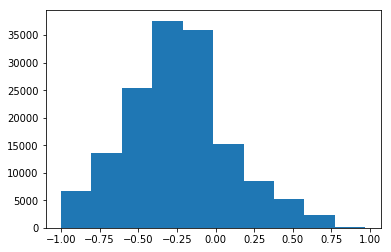

In [18]:
plt.hist(np.reshape(img, (IMAGE_DIMS[0]*IMAGE_DIMS[1]*3)))

### Denorm and save image

In [19]:
img+=1.
img/=2.

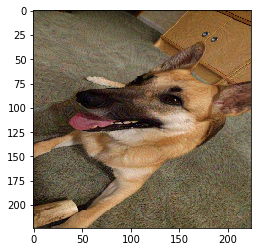

In [20]:
plt.imshow(img)

In [21]:
plt.imsave("test.png", img)

### More verification

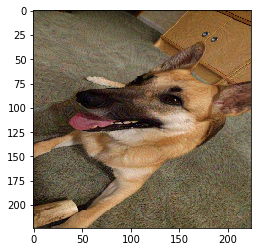

In [22]:
test = Image.open("./test.png").resize(IMAGE_DIMS)
plt.imshow(test);
test = prepare_image(test)

In [24]:
evaled = model.predict(test)
print(np.argmax(evaled))
print(evaled[0][TREE_FROG_IDX])

31
0.999819


In [25]:
print(is_similar_img("test.png", "trixi.png"))

True
